# Quality Check of ATTO-Campina Ceilometer ("CHM15k Nimbus")
by Friederike Lipken (lipken@usp.br) 4/2025

## Import Packages, load data, define varibales

In [ ]:
import datetime
import netCDF4 as nc
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mp
import xarray as xr
import os
import glob
import requests
from bs4 import BeautifulSoup
from collections import defaultdict
# imports can be found later in the code as well, if only specific code-subset is run

## 1. Time series of Ceilo@Campina

#### prepare folders

In [2]:
#delete all dat-files
root_dir = "/media/flipken/Elements/PhD_ATTO/Ceilo_Campina/All_Data"

deleted_files = 0

for dirpath, dirnames, filenames in os.walk(root_dir):
    for file in filenames:
        if file.endswith(".dat"):
            full_path = os.path.join(dirpath, file)
            try:
                os.remove(full_path)
                deleted_files += 1
                print(f"Deleted: {full_path}")
            except Exception as e:
                print(f"Failed to delete {full_path}: {e}")

print(f"Deleted {deleted_files} .dat files.")

Deleted: /media/flipken/Elements/PhD_ATTO/Ceilo_Campina/All_Data/2021/07/CHM160146_2021-07-23.dat
Deleted: /media/flipken/Elements/PhD_ATTO/Ceilo_Campina/All_Data/2021/09/CHM160146_2021-09-08.dat
Deleted: /media/flipken/Elements/PhD_ATTO/Ceilo_Campina/All_Data/2021/09/CHM160146_2021-09-09.dat
Deleted: /media/flipken/Elements/PhD_ATTO/Ceilo_Campina/All_Data/2021/11/CHM160146_2021-11-01.dat
Deleted: /media/flipken/Elements/PhD_ATTO/Ceilo_Campina/All_Data/2021/11/CHM160146_2021-11-02.dat
Deleted: /media/flipken/Elements/PhD_ATTO/Ceilo_Campina/All_Data/2021/11/CHM160146_2021-11-08.dat
Deleted: /media/flipken/Elements/PhD_ATTO/Ceilo_Campina/All_Data/2021/11/CHM160146_2021-11-16.dat
Deleted: /media/flipken/Elements/PhD_ATTO/Ceilo_Campina/All_Data/2021/11/CHM160146_2021-11-17.dat
Deleted: /media/flipken/Elements/PhD_ATTO/Ceilo_Campina/All_Data/2021/11/CHM160146_2021-11-18.dat
Deleted: /media/flipken/Elements/PhD_ATTO/Ceilo_Campina/All_Data/2021/11/CHM160146_2021-11-19.dat
Deleted: /media/flip

In [ ]:
# delete all files that are double (delete the '_000' files)
# dictionary 
files_by_date = defaultdict(list)

#Collect all .nc files and group by date
for dirpath, _, filenames in os.walk(root_dir):
    for file in filenames:
        if file.endswith(".nc"):
            date_prefix = file[:8]
            full_path = os.path.join(dirpath, file)
            files_by_date[date_prefix].append((file, full_path))

#Foor each date, check for _000 and regular version
deleted_count = 0

for date, file_list in files_by_date.items():
    regular = [f for f in file_list if not f[0].endswith("_000.nc")]
    duplicate = [f for f in file_list if f[0].endswith("_000.nc")]

    if regular and duplicate:
        # delete all _000 versions if other version exists
        for dup_file, dup_path in duplicate:
            try:
                os.remove(dup_path)
                deleted_count += 1
                print(f"Deleted duplicate: {dup_path}")
            except Exception as e:
                print(f"Failed to delete {dup_path}: {e}")

print(f"Deleted {deleted_count} duplicate '_000' files.")

Deleted duplicate: /media/flipken/Elements/PhD_ATTO/Ceilo_Campina/All_Data/2021/09/20210908_ATTO_CHM160146_000.nc
Deleted duplicate: /media/flipken/Elements/PhD_ATTO/Ceilo_Campina/All_Data/2021/09/20210909_ATTO_CHM160146_000.nc
Deleted duplicate: /media/flipken/Elements/PhD_ATTO/Ceilo_Campina/All_Data/2021/09/20210911_ATTO_CHM160146_000.nc
Deleted duplicate: /media/flipken/Elements/PhD_ATTO/Ceilo_Campina/All_Data/2021/10/20211101_ATTO_CHM160146_000.nc
Deleted duplicate: /media/flipken/Elements/PhD_ATTO/Ceilo_Campina/All_Data/2021/11/20211122_ATTO_CHM160146_000.nc
Deleted duplicate: /media/flipken/Elements/PhD_ATTO/Ceilo_Campina/All_Data/2021/11/20211102_ATTO_CHM160146_000.nc
Deleted duplicate: /media/flipken/Elements/PhD_ATTO/Ceilo_Campina/All_Data/2021/11/20211108_ATTO_CHM160146_000.nc
Deleted duplicate: /media/flipken/Elements/PhD_ATTO/Ceilo_Campina/All_Data/2021/11/20211117_ATTO_CHM160146_000.nc
Deleted duplicate: /media/flipken/Elements/PhD_ATTO/Ceilo_Campina/All_Data/2021/11/20211

### load all data (for time series)

In [ ]:
# define path
root_dir = "/media/flipken/Elements/PhD_ATTO/Ceilo_Campina/All_Data"
# define variables
variables = ["state_optics", "state_detector", "state_laser", "temp_lom", "temp_int", "temp_ext"]
# list for all data
data_list = []

In [7]:
#go through folders and process each nc file
for dirpath, _, filenames in os.walk(root_dir):
    for file in filenames:
        if file.endswith(".nc"):
            full_path = os.path.join(dirpath, file)
            try:
                ds = xr.open_dataset(full_path)
                
                # to check if all variables xist
                if all(var in ds.variables for var in variables):
                    df = ds[variables].to_dataframe().reset_index()
                    
                    # get date from time variable
                    df["date"] = pd.to_datetime(df["time"]).dt.date
                    
                    # average daily
                    daily_avg = df.groupby("date")[variables].mean().reset_index()
                    data_list.append(daily_avg)
                    
                ds.close()
            except Exception as e:
                print(f"Failed to load {full_path}: {e}")

Failed to load /media/flipken/Elements/PhD_ATTO/Ceilo_Campina/All_Data/2024/04/20240401_ATTO_CHM160146.nc: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
Failed to load /media/flipken/Elements/PhD_ATTO/Ceilo_Campina/All_Data/2024/10/20241019_ATTO_CHM160146.nc: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
Failed to load /media/flipken/Elements/PhD_ATTO/Ceilo_Campina/All_Data/2024/

In [8]:
# Combine all daily averages
if data_list:
    full_df = pd.concat(data_list)
    full_df = full_df.groupby("date")[variables].mean().reset_index()  # Merge duplicates
    print(full_df.head())
else:
    print("No valid data found.")

         date  state_optics  state_detector  state_laser    temp_lom  \
0  1904-01-01      0.000000             0.0          0.0    0.000000   
1  2021-07-23     54.436214           100.0        100.0  307.878601   
2  2021-09-08     43.565217           100.0        100.0  309.115936   
3  2021-09-09     76.398148           100.0        100.0  311.727783   
4  2021-09-10     63.152951           100.0        100.0  308.771484   

     temp_int    temp_ext  
0    0.000000    0.000000  
1  300.196899  291.854736  
2  307.137054  307.530640  
3  311.268524  309.558350  
4  306.038940  301.545105  


In [12]:
print(full_df["date"])

0       1904-01-01
1       2021-07-23
2       2021-09-08
3       2021-09-09
4       2021-09-10
           ...    
1243    2025-04-11
1244    2025-04-12
1245    2025-04-13
1246    2025-04-14
1247    2025-04-15
Name: date, Length: 1248, dtype: object


In [13]:
# remove first date, because its 1904-01-01
full_df = full_df[full_df['date'] > pd.to_datetime("2021-01-01").date()]

### Plot time series of state of ceilometer

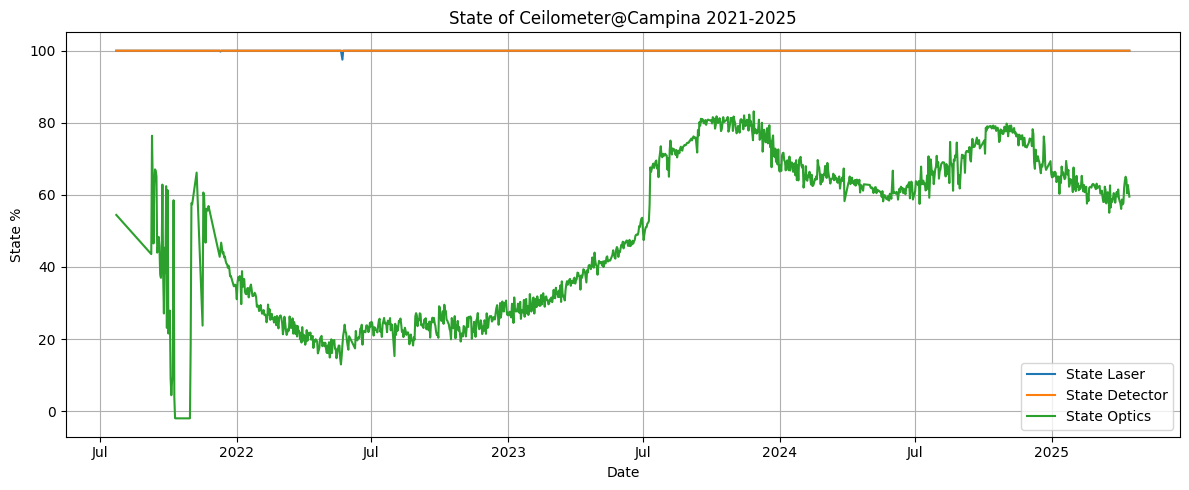

In [ ]:
# plot state of Laser, Detector, and Optics
plt.figure(figsize=(12, 5))

plt.plot(full_df['date'], full_df['state_laser'], label='State Laser')
plt.plot(full_df['date'], full_df['state_detector'], label='State Detector')
plt.plot(full_df['date'], full_df['state_optics'], label='State Optics')

plt.ylabel('State %')
plt.title('State of Ceilometer@Campina 2021-2025')
plt.xlabel('Date')
plt.legend()
plt.grid(True)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

plt.tight_layout()
#plt.savefig("/media/flipken/Elements/PhD_ATTO/Ceilo_Campina/Qualitycheck_data/figures/timeseries_Ceilo_Campina/Ceilo_Campina_States.png", dpi=150, format='png', facecolor='white', bbox_inches='tight')
plt.show()


In [16]:
#check for negative values
negatives = full_df[
    (full_df["state_optics"] < 0)
]

print(f"\nFound {len(negatives)} rows with negative values:")
print(negatives)


Found 21 rows with negative values:
          date  state_optics  state_detector  state_laser    temp_lom  \
34  2021-10-10     -1.978031           100.0        100.0  310.429199   
35  2021-10-11     -2.000000           100.0        100.0  311.184021   
36  2021-10-12     -1.986070           100.0        100.0  311.024323   
37  2021-10-13     -2.000000           100.0        100.0  311.627533   
38  2021-10-14     -2.000000           100.0        100.0  311.465332   
39  2021-10-15     -1.992163           100.0        100.0  311.350952   
40  2021-10-16     -2.000000           100.0        100.0  308.688568   
41  2021-10-17     -2.000000           100.0        100.0  307.953186   
42  2021-10-18     -2.000000           100.0        100.0  309.984283   
43  2021-10-19     -2.000000           100.0        100.0  310.688110   
44  2021-10-20     -2.000000           100.0        100.0  307.581085   
45  2021-10-21     -2.000000           100.0        100.0  308.043884   
46  2021-10-22

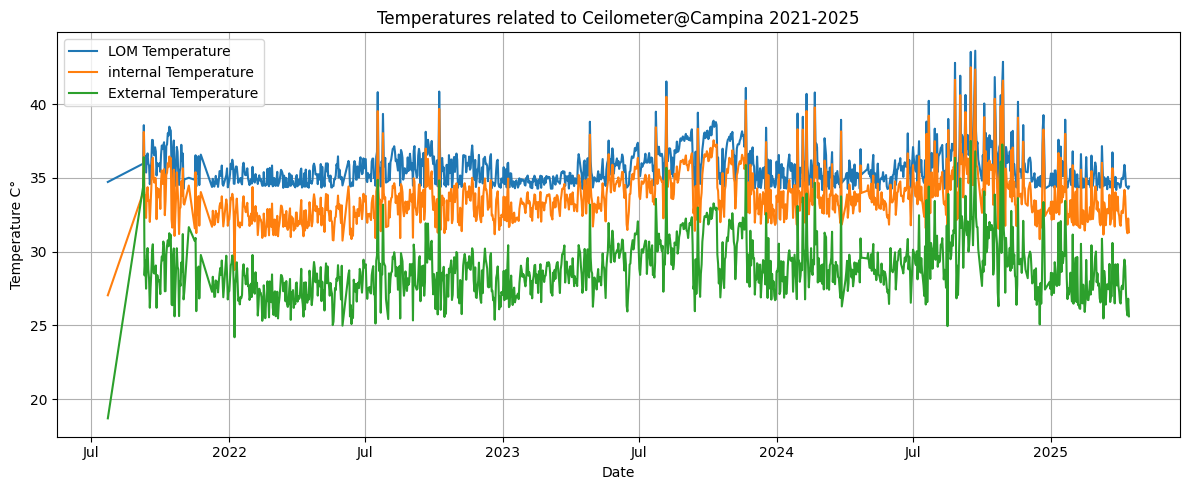

In [ ]:
# Plot temperature variables
plt.figure(figsize=(12, 5))

plt.plot(full_df['date'], full_df['temp_lom']-273.15, label='LOM Temperature')
plt.plot(full_df['date'], full_df['temp_int']-273.15, label='internal Temperature')
plt.plot(full_df['date'], full_df['temp_ext']-273.15, label='External Temperature')

plt.ylabel('Temperature C°')
plt.title('Temperatures related to Ceilometer@Campina 2021-2025')
plt.xlabel('Date')
plt.legend()
plt.grid(True)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

plt.tight_layout()
#plt.savefig("/media/flipken/Elements/PhD_ATTO/Ceilo_Campina/Qualitycheck_data/figures/timeseries_Ceilo_Campina/Ceilo_Campina_Temps.png", dpi=150, format='png', facecolor='white', bbox_inches='tight')
plt.show()

## 2. Example comparison between Ceilometer at beginning vs. now

In [ ]:
# Load data
# at beginning of measurements
ds_start = nc.Dataset("/media/flipken/Elements/PhD_ATTO/Ceilo_Campina/Qualitycheck_data/20211016_ATTO_CHM160146_000.nc", mode='r')

# Now
ds_now = nc.Dataset("/media/flipken/Elements/PhD_ATTO/Ceilo_Campina/Qualitycheck_data/20250401_ATTO_CHM160146.nc", mode='r')

In [ ]:
# define time and convert it for measurements at the beginning
time_start = ds_start['time'][:]
time_units = ds_start['time'].units  # (seconds since 1904-01-01 00:00:00.000 00:00)
time_cftime = nc.num2date(time_start, time_units) 
time_start_standard = [datetime.datetime(t.year, t.month, t.day, t.hour, t.minute, t.second) for t in time_cftime]

# define variables
state_laser_start = ds_start['state_laser'][:]
state_detector_start = ds_start['state_detector'][:]
state_optics_start = ds_start['state_optics'][:]

int_temp_start = ds_start['temp_int'][:]-273.15
ext_temp_start = ds_start['temp_ext'][:]-273.15
det_temp_start = ds_start['temp_det'][:]-273.15
temp_lom_start = ds_start['temp_lom'][:]-273.15

In [ ]:
# Plot 
plt.figure(figsize=(10, 5))
plt.plot(time_start_standard, state_laser_start, label='State Laser')
plt.plot(time_start_standard, state_detector_start, label='State Detector')
plt.plot(time_start_standard, state_optics_start, label='State Optics')

plt.ylabel('%')
plt.title('State at beginning of measurements')
plt.legend()
plt.grid(True)

locator = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

plt.show()

In [ ]:
# Plot 
plt.figure(figsize=(10, 5))
plt.plot(time_start_standard, int_temp_start, label='Temp. Internal')
plt.plot(time_start_standard, ext_temp_start, label='Temp. External')
plt.plot(time_start_standard, det_temp_start, label='Temp. Detector')
plt.plot(time_start_standard, temp_lom_start, label='Temp. LOM')

plt.ylabel('%')
plt.title('Temperatures at beginning of measurements')
plt.legend()
plt.grid(True)

locator = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

plt.show()

In [ ]:
# Define time and convert it for current measurements
time_now = ds_now['time'][:]
time_now_units = ds_now['time'].units  # (seconds since 1904-01-01 00:00:00.000 00:00)
time_now_cftime = nc.num2date(time_now, time_now_units)  #convert to datetime
time_now_standard = [datetime.datetime(t.year, t.month, t.day, t.hour, t.minute, t.second) for t in time_now_cftime]

# Extract state variables
state_laser_now = ds_now['state_laser'][:]
state_detector_now = ds_now['state_detector'][:]
state_optics_now = ds_now['state_optics'][:]

# Extract temperature variables
int_temp_now = ds_now['temp_int'][:]-273.15
ext_temp_now = ds_now['temp_ext'][:]-273.15
det_temp_now = ds_now['temp_det'][:]-273.15
temp_lom_now = ds_now['temp_lom'][:]-273.15

In [ ]:
# Plot State of Ceilometer
plt.figure(figsize=(10, 5))
plt.plot(time_now_standard, state_laser_now, label='State Laser')
plt.plot(time_now_standard, state_detector_now, label='State Detector')
plt.plot(time_now_standard, state_optics_now, label='State Optics')

plt.ylabel('%')
plt.title('State Now')
plt.legend()
plt.grid(True)

locator = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

plt.show()

In [ ]:
# Plot temperature if Ceilometer
plt.figure(figsize=(10, 5))
plt.plot(time_now_standard, int_temp_now, label='Temp. Internal')
plt.plot(time_now_standard, ext_temp_now, label='Temp. External')
plt.plot(time_now_standard, det_temp_now, label='Temp. Detector')
plt.plot(time_now_standard, temp_lom_now, label='Temp. LOM')

plt.ylabel('°C')
plt.title('Temperatures now')
plt.legend()
plt.grid(True)

locator = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

plt.show()

## 3. Comparison of Ceilometer @Campina and @Tower

#### Ceilo@Tower

In [33]:
#Load data from ATTO Ceilo
ds_Tower = xr.open_mfdataset('/media/flipken/Elements/PhD_ATTO/Ceilo_Campina/Qualitycheck_data/Ceilometer_ATTO_Tower/2021/02/2021*.nc')   
ds_Tower_Jan = xr.open_mfdataset('/media/flipken/Elements/PhD_ATTO/Ceilo_Campina/Qualitycheck_data/Ceilometer_ATTO_Tower/2021/01/2021*.nc')   

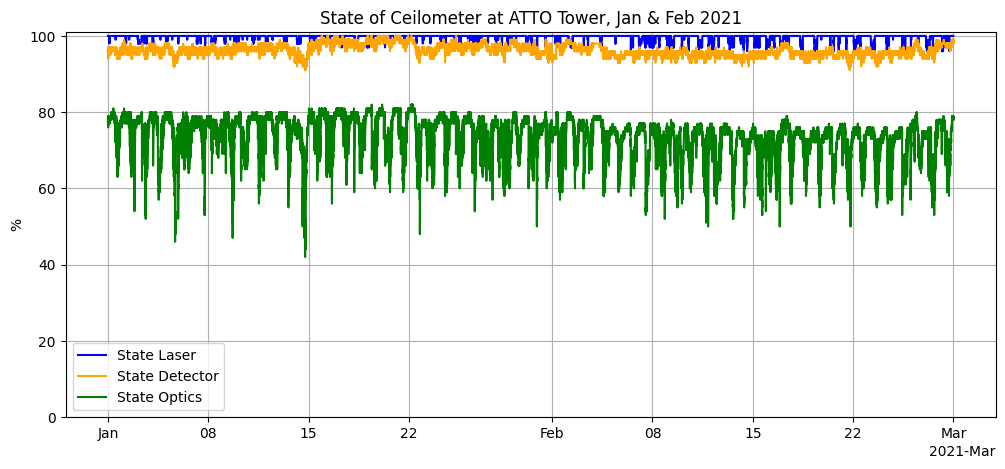

In [ ]:
plt.figure(figsize=(12, 5))
# Create the plots with state variables
plt.plot(ds_Tower['time'], ds_Tower['state_laser'], label='State Laser', color='blue')
plt.plot(ds_Tower_Jan['time'], ds_Tower_Jan['state_laser'], color='blue')
plt.plot(ds_Tower['time'], ds_Tower['state_detector'], label='State Detector', color='orange')
plt.plot(ds_Tower_Jan['time'], ds_Tower_Jan['state_detector'], color='orange')
plt.plot(ds_Tower['time'], ds_Tower['state_optics'], label='State Optics', color='green')
plt.plot(ds_Tower_Jan['time'], ds_Tower_Jan['state_optics'], color='green')
plt.ylabel('%')
plt.title('State of Ceilometer at ATTO Tower, Jan & Feb 2021')    
plt.legend()
plt.grid('on')
plt.ylim(0, 101)
locator=mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
#plt.savefig('/media/flipken/Elements/PhD_ATTO/Ceilo_Campina/Qualitycheck_data/figures/Ceilo_ATTO/Ceilo_ATTO_State_Jan_Feb_2021.png', dpi=150, format='png', facecolor='white', bbox_inches='tight')

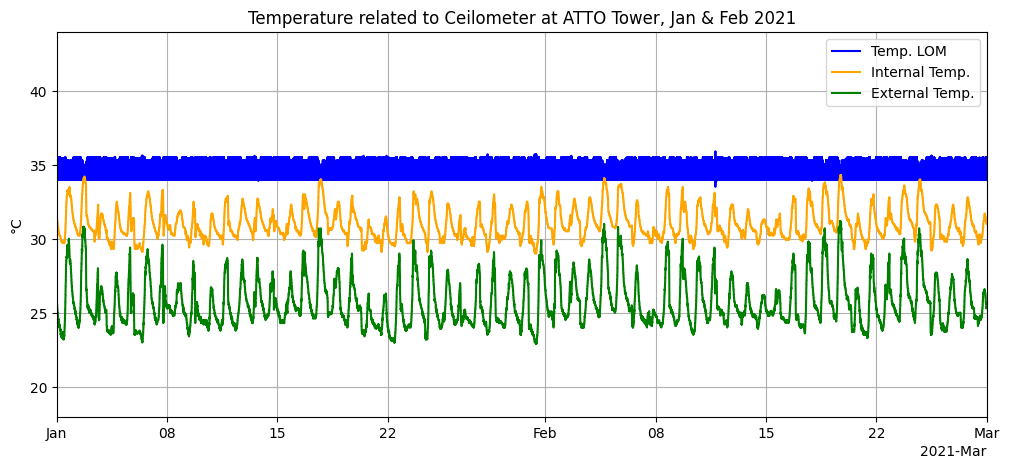

In [ ]:
plt.figure(figsize=(12, 5))
# Create the plots with state variables
plt.plot(ds_Tower['time'], ds_Tower['temp_lom']-273.15, label='Temp. LOM', color='blue')
plt.plot(ds_Tower_Jan['time'], ds_Tower_Jan['temp_lom']-273.15, color='blue')
plt.plot(ds_Tower['time'], ds_Tower['temp_int']-273.15, label='Internal Temp.', color='orange')
plt.plot(ds_Tower_Jan['time'], ds_Tower_Jan['temp_int']-273.15, color='orange')
plt.plot(ds_Tower['time'], ds_Tower['temp_ext']-273.15, label='External Temp.', color='green')
plt.plot(ds_Tower_Jan['time'], ds_Tower_Jan['temp_ext']-273.15, color='green')
plt.ylabel('°C')
plt.ylim(18,44)
plt.title('Temperature related to Ceilometer at ATTO Tower, Jan & Feb 2021')    
plt.legend()
plt.grid('on')
locator=mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
plt.xlim(pd.to_datetime("2021-01-01"), pd.to_datetime("2021-03-01"))
#plt.savefig('/media/flipken/Elements/PhD_ATTO/Ceilo_Campina/Qualitycheck_data/figures/Ceilo_ATTO/Ceilo_ATTO_Temp_Jan_Feb_2021.png', dpi=150, format='png', facecolor='white', bbox_inches='tight')

##### Ceilo@Campina

In [61]:
#Load data from Campina Ceilo
ds_Camp0125 = xr.open_mfdataset('/media/flipken/Elements/PhD_ATTO/Ceilo_Campina/All_Data/2023/01/2023*.nc')   
ds_Camp0225 = xr.open_mfdataset('/media/flipken/Elements/PhD_ATTO/Ceilo_Campina/All_Data/2023/02/2023*.nc')   

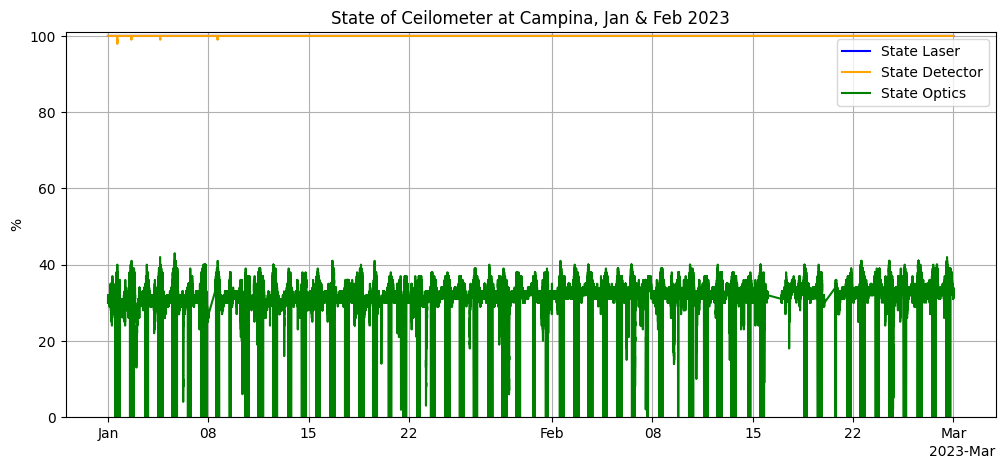

In [ ]:
plt.figure(figsize=(12, 5))
# Create the plots with state variables
plt.plot(ds_Camp0225['time'], ds_Camp0225['state_laser'], label='State Laser', color='blue')
plt.plot(ds_Camp0125['time'], ds_Camp0125['state_laser'], color='blue')
plt.plot(ds_Camp0225['time'], ds_Camp0225['state_detector'], label='State Detector', color='orange')
plt.plot(ds_Camp0125['time'], ds_Camp0125['state_detector'], color='orange')
plt.plot(ds_Camp0225['time'], ds_Camp0225['state_optics'], label='State Optics', color='green')
plt.plot(ds_Camp0125['time'], ds_Camp0125['state_optics'], color='green')
plt.ylabel('%')
plt.title('State of Ceilometer at Campina, Jan & Feb 2023')    
plt.legend()
plt.grid('on')
plt.ylim(0, 101)
locator=mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
#plt.savefig('/media/flipken/Elements/PhD_ATTO/Ceilo_Campina/Qualitycheck_data/figures/Ceilo_ATTO/Ceilo_Campina_State_Jan_Feb_2021.png', dpi=150, format='png', facecolor='white', bbox_inches='tight')

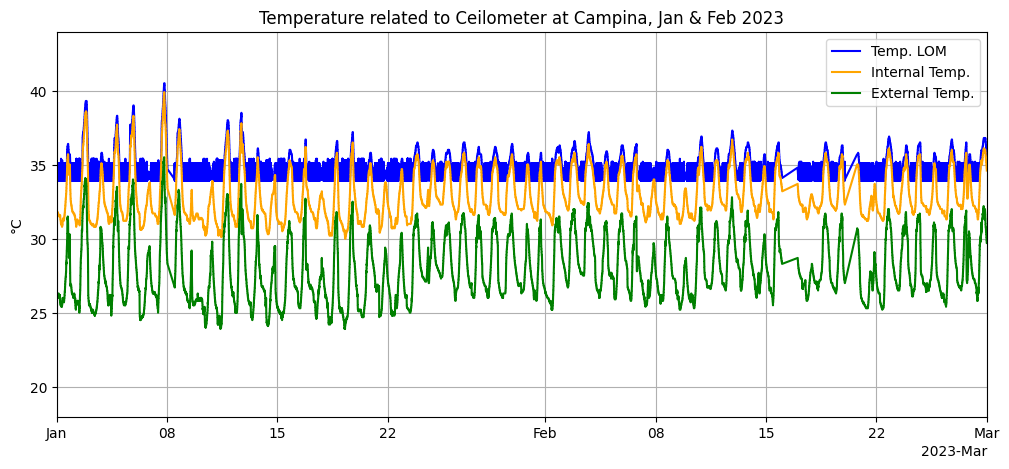

In [ ]:
plt.figure(figsize=(12, 5))
# Create the plots with temperature variables
plt.plot(ds_Camp0225['time'], ds_Camp0225['temp_lom']-273.15, label='Temp. LOM', color='blue')
plt.plot(ds_Camp0125['time'], ds_Camp0125['temp_lom']-273.15, color='blue')
plt.plot(ds_Camp0225['time'], ds_Camp0225['temp_int']-273.15, label='Internal Temp.', color='orange')
plt.plot(ds_Camp0125['time'], ds_Camp0125['temp_int']-273.15, color='orange')
plt.plot(ds_Camp0225['time'], ds_Camp0225['temp_ext']-273.15, label='External Temp.', color='green')
plt.plot(ds_Camp0125['time'], ds_Camp0125['temp_ext']-273.15, color='green')
plt.ylabel('°C')
plt.ylim(18,44)
plt.title('Temperature related to Ceilometer at Campina, Jan & Feb 2023')    
plt.legend()
plt.grid('on')
locator=mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
plt.xlim(pd.to_datetime("2023-01-01"), pd.to_datetime("2023-03-01"))
#plt.savefig('/media/flipken/Elements/PhD_ATTO/Ceilo_Campina/Qualitycheck_data/figures/Ceilo_ATTO/Ceilo_Campina_Temp_Jan_Feb_2021.png', dpi=150, format='png', facecolor='white', bbox_inches='tight')

## 4. Plot Cloud Base with Comparison to ERA5

In [1]:
import datetime as dt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mp
import netCDF4 as nc
import xarray as xr
import os
import glob

In [2]:
path ="/media/flipken/Elements/PhD_ATTO/Ceilo_Campina/All_Data/2023/09/20230908_ATTO_CHM160146.nc"
ds = nc.Dataset(path, mode='r')

In [ ]:
# define cloud base height 
cbh = ds.variables['cbh'][:]  # shape (time, layer)
cbh = cbh.astype(float)
cbh[cbh <= 0] = np.nan  

In [ ]:
# define time and convert
time = ds.variables['time']
time_units = time.units
time_array = nc.num2date(time[:], units=time_units, only_use_cftime_datetimes=False)
time_array = np.array(time_array)

In [ ]:
# target date
target_date = dt.datetime(2023, 9, 8)
mask = np.array([t.date() == target_date.date() for t in time_array])
filtered_times = time_array[mask]
filtered_cbh = cbh[mask, :]  # shape (n_times, n_layers)

# needs to be flatten for scatter plot
cbh_flat = filtered_cbh.flatten()
time_repeated = np.repeat(filtered_times, filtered_cbh.shape[1])

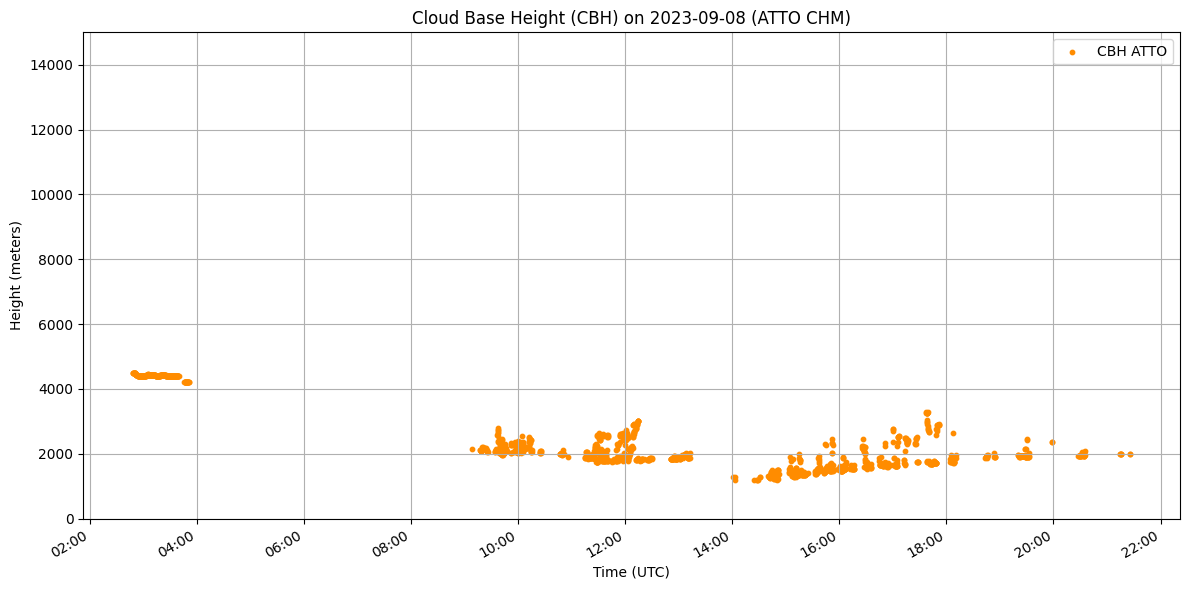

In [10]:
# Plot
plt.figure(figsize=(12, 6))
plt.scatter(time_repeated, cbh_flat, color='darkorange', s=10, label='CBH ATTO')
plt.title('Cloud Base Height (CBH) on 2023-09-08 (ATTO CHM)')
plt.xlabel('Time (UTC)')
plt.ylabel('Height (meters)')
plt.ylim(0, 15000)
plt.grid(True)
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

### Plot Ceilometer and ERA5 togethere

In [1]:
import os
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

In [2]:
path_atto = "/media/flipken/Elements/PhD_ATTO/Ceilo_Campina/All_Data/2023/09/20230908_ATTO_CHM160146.nc"
ds_atto = nc.Dataset(path_atto, mode='r')

In [ ]:
ds_atto.variables

In [ ]:
#define variables of Campina Ceilometer
cbh_atto = ds_atto.variables['cbh'][:].astype(float)
cbh_atto[cbh_atto <= 0] = np.nan  # remove zero and negative values
time_atto = ds_atto.variables['time']
time_atto_array = nc.num2date(time_atto[:], units=time_atto.units, only_use_cftime_datetimes=False)
time_atto_array = np.array(time_atto_array)

In [5]:
# Filter for 2023-09-08
target_date = dt.datetime(2023, 9, 8)
mask_atto = np.array([t.date() == target_date.date() for t in time_atto_array])
filtered_times_atto = time_atto_array[mask_atto]
filtered_cbh_atto = cbh_atto[mask_atto, :]
cbh_flat_atto = filtered_cbh_atto.flatten()
time_repeated_atto = np.repeat(filtered_times_atto, filtered_cbh_atto.shape[1])
valid_atto = ~np.isnan(cbh_flat_atto)
cbh_flat_atto = cbh_flat_atto[valid_atto]
time_repeated_atto = time_repeated_atto[valid_atto]

In [ ]:
# load ERA5 data
ds_era5 = nc.Dataset('/media/flipken/Elements/PhD_ATTO/Ceilo_Campina/Qualitycheck_data/ERA5_Data/ERA5_hourly_on_single_levels_ATTO_CB.nc')
cbh_era5 = ds_era5.variables['cbh']
time_era5 = ds_era5.variables['valid_time']
time_era5_array = nc.num2date(time_era5[:], units=time_era5.units, only_use_cftime_datetimes=False)
time_era5_array = np.array(time_era5_array)

In [ ]:
# prep data
mask_era5 = np.array([t.date() == target_date.date() for t in time_era5_array])
filtered_times_era5 = time_era5_array[mask_era5]
filtered_cbh_era5 = cbh_era5[mask_era5, :, :]  # shape (n_times, 5, 5)
cbh_flat_era5 = filtered_cbh_era5.reshape(-1)
time_repeated_era5 = np.repeat(filtered_times_era5, 25)
valid_era5 = ~np.isnan(cbh_flat_era5)
cbh_flat_era5 = cbh_flat_era5[valid_era5]
time_repeated_era5 = time_repeated_era5[valid_era5]

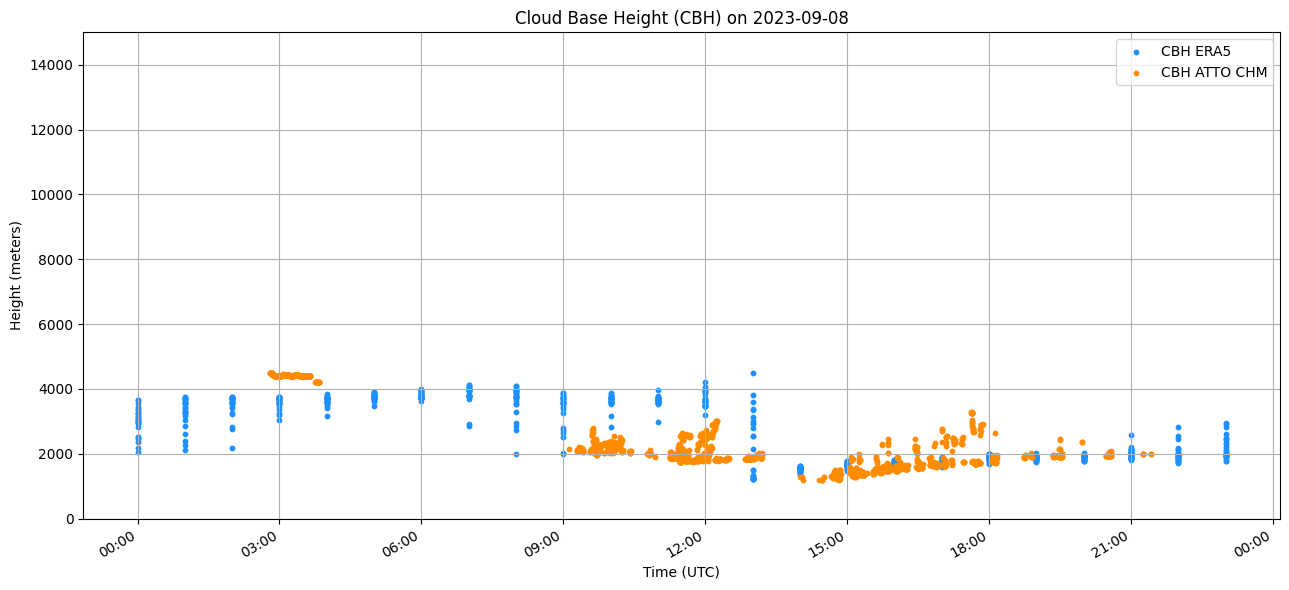

In [ ]:
# Plot CBH from ERA5 and Ceilo@Campina togethere
plt.figure(figsize=(13, 6))
plt.scatter(time_repeated_era5, cbh_flat_era5, color='dodgerblue', s=10, label='CBH ERA5')
plt.scatter(time_repeated_atto, cbh_flat_atto, color='darkorange', s=10, label='CBH ATTO CHM')

plt.title('Cloud Base Height (CBH) on 2023-09-08')
plt.xlabel('Time (UTC)')
plt.ylabel('Height (meters)')
plt.ylim(0, 15000)
plt.grid(True)
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
#plt.show()
#plt.savefig('/media/flipken/Elements/PhD_ATTO/Ceilo_Campina/Qualitycheck_data/figures/ERA5_Ceilo_Scatterplot_08092023.png', dpi=150, format='png', facecolor='white', bbox_inches='tight')

### Plot cbh from Ceilo and ERA5 together with beta_raw

In [ ]:
import os
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

In [ ]:
path_atto = "/media/flipken/Elements/PhD_ATTO/Ceilo_Campina/All_Data/2023/09/20230908_ATTO_CHM160146.nc"
ds_atto = nc.Dataset(path_atto, mode='r')

# Extract CBH
cbh_atto = ds_atto.variables['cbh'][:].astype(float)
cbh_atto[cbh_atto <= 0] = np.nan
time_atto = ds_atto.variables['time']
time_atto_array = nc.num2date(time_atto[:], units=time_atto.units, only_use_cftime_datetimes=False)
time_atto_array = np.array(time_atto_array)

# Extract beta_raw
beta_raw = ds_atto.variables['beta_raw'][:].astype(float)
beta_raw[beta_raw > 1e35] = np.nan  # clean FillValue with nans
range_bins = ds_atto.variables['range'][:]  # in meters

# Filter for 2023-09-08
target_date = dt.datetime(2023, 9, 8)
mask_atto = np.array([t.date() == target_date.date() for t in time_atto_array])
filtered_times_atto = time_atto_array[mask_atto]
filtered_cbh_atto = cbh_atto[mask_atto, :]
filtered_beta = beta_raw[mask_atto, :]

# Flatten CBH for plotting
cbh_flat_atto = filtered_cbh_atto.flatten()
time_repeated_atto = np.repeat(filtered_times_atto, filtered_cbh_atto.shape[1])
valid_atto = ~np.isnan(cbh_flat_atto)
cbh_flat_atto = cbh_flat_atto[valid_atto]
time_repeated_atto = time_repeated_atto[valid_atto]

In [11]:
ds_era5 = nc.Dataset('/media/flipken/Elements/PhD_ATTO/Ceilo_Campina/Qualitycheck_data/ERA5_Data/ERA5_hourly_on_single_levels_ATTO_CB.nc')
cbh_era5 = ds_era5.variables['cbh']
time_era5 = ds_era5.variables['valid_time']
time_era5_array = nc.num2date(time_era5[:], units=time_era5.units, only_use_cftime_datetimes=False)
time_era5_array = np.array(time_era5_array)

mask_era5 = np.array([t.date() == target_date.date() for t in time_era5_array])
filtered_times_era5 = time_era5_array[mask_era5]
filtered_cbh_era5 = cbh_era5[mask_era5, :, :]
cbh_flat_era5 = filtered_cbh_era5.reshape(-1)
time_repeated_era5 = np.repeat(filtered_times_era5, 25)
valid_era5 = ~np.isnan(cbh_flat_era5)
cbh_flat_era5 = cbh_flat_era5[valid_era5]
time_repeated_era5 = time_repeated_era5[valid_era5]

/home/flipken/anaconda3/envs/flipken/lib/python3.9/site-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/tmp/ipykernel_67604/4263883431.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/flipken/anaconda3/envs/flipken/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


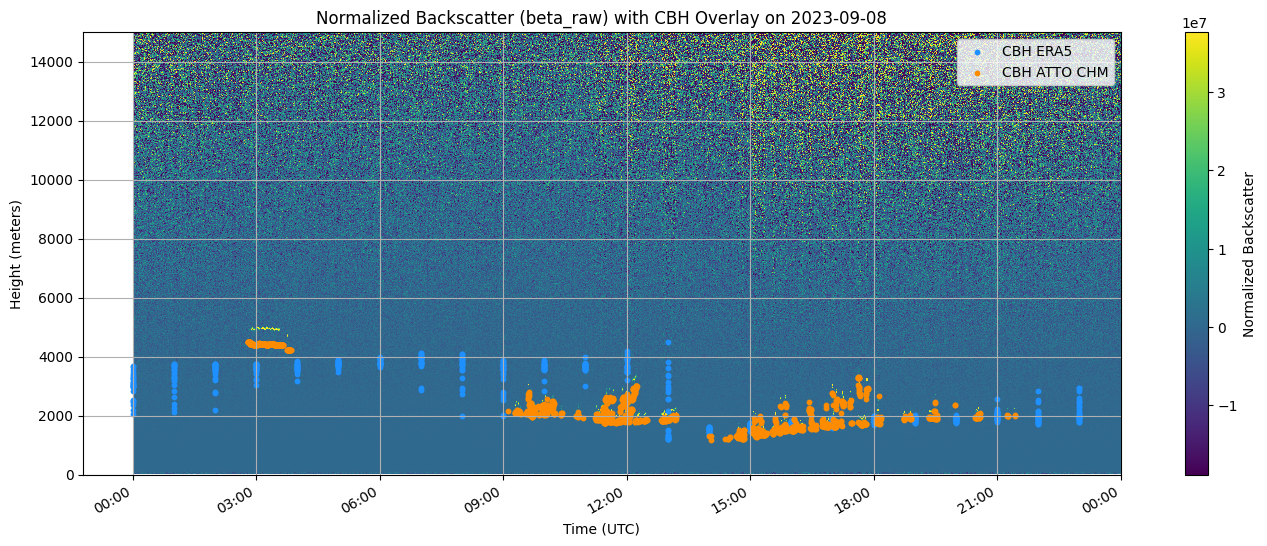

In [ ]:
# Colorplot with CBH overlay
fig, ax = plt.subplots(figsize=(14, 6))

time_mesh, range_mesh = np.meshgrid(filtered_times_atto, range_bins)

# transpose beta_raw to (range, time) for pcolormesh
pcm = ax.pcolormesh(time_mesh, range_mesh, filtered_beta.T,
                    shading='auto', cmap='viridis', vmin=np.nanpercentile(filtered_beta, 5), vmax=np.nanpercentile(filtered_beta, 99))

# overlay
ax.scatter(time_repeated_era5, cbh_flat_era5, color='dodgerblue', s=10, label='CBH ERA5')
ax.scatter(time_repeated_atto, cbh_flat_atto, color='darkorange', s=10, label='CBH ATTO CHM')

ax.set_title('Normalized Backscatter (beta_raw) with CBH Overlay on 2023-09-08')
ax.set_ylabel('Height (meters)')
ax.set_xlabel('Time (UTC)')
ax.set_ylim(0, 15000)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.colorbar(pcm, ax=ax, label='Normalized Backscatter')
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()